In [14]:
import promonet
import ppgs
import os
from pathlib import Path
import torch
import torchaudio
import IPython
import pysodic
import matplotlib.pyplot as plt

In [120]:
audio, sample_rate = torchaudio.load('tomato.wav')
print(audio.shape)
audio = promonet.resample(audio, sample_rate)
print(audio.shape)
torchaudio.save('tomato-resampled.wav', audio, sample_rate=promonet.SAMPLE_RATE)

torch.Size([1, 53440])
torch.Size([1, 73647])


In [128]:
audio_file = Path('0016-000784-100.wav')
model = 'w2v2fb-ppg'
# model = 'bottleneck-latents'
config_dir = promonet.ROOT_DIR / 'config' / 'ppgs-experiments'
ppgs_config_dir = config_dir / 'ppgs'
promonet_config_dir = config_dir / 'promonet'
assert ppgs_config_dir.exists()
assert promonet_config_dir.exists()
IPython.display.Audio(audio_file)

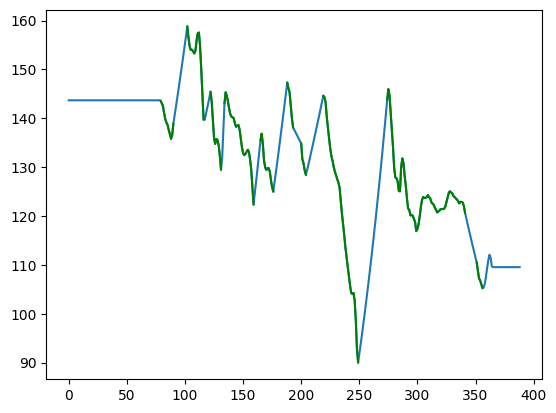

In [107]:
# Shift pitch into range
speaker_pitch, periodicity, loudness, _ = pysodic.from_audio(
    torchaudio.load(audio_file)[0],
    22500,
    promonet.HOPSIZE / promonet.SAMPLE_RATE,
    promonet.WINDOW_SIZE / promonet.SAMPLE_RATE,
)
voiced = speaker_pitch.clone()
voiced[periodicity < 0.1625] = torch.nan
target_mean = speaker_pitch.mean()
target_max = speaker_pitch.max()
target_min = speaker_pitch.min()
plt.plot(speaker_pitch.squeeze())
plt.plot(voiced.squeeze(), color='green')

In [125]:
audio_file = Path('tomato-resampled.wav')
IPython.display.Audio(audio_file)

tensor(1.5211)


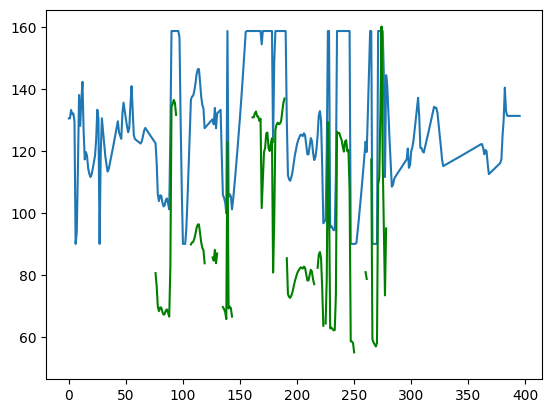

In [109]:
pitch, periodicity, loudness, _ = pysodic.from_audio(
    torchaudio.load(audio_file)[0],
    16000,
    promonet.HOPSIZE / promonet.SAMPLE_RATE,
    promonet.WINDOW_SIZE / promonet.SAMPLE_RATE,
    voicing_threshold=0.1625
)
ratio = target_mean/pitch.mean()
print(ratio)
voiced = pitch.clone()
voiced[periodicity < 0.1625] = torch.nan
pitch *= ratio
pitch = pitch.clamp(target_min, target_max)
pitch_file = audio_file.parent / f'{audio_file.stem}-pitch.pt'
torch.save(pitch, pitch_file)
plt.plot(pitch.squeeze())
# plt.plot(speaker_pitch.squeeze(), color='red')
plt.plot(voiced.squeeze(), color = 'green')

In [119]:
# Create original ppg file
ppg_file = Path(audio_file.parent / f'{audio_file.stem}-{model}.pt')
print(ppg_file)

command = 'python -m ppgs '
command += f'--sources {audio_file} '
command += f'--sinks {ppg_file} '
command += f'--config {ppgs_config_dir / (model + ".py")} '
command += f'--gpu 0'

print(command)

os.system(command)

0016-000784-100-bottleneck-latents.pt
python -m ppgs --sources 0016-000784-100.wav --sinks 0016-000784-100-bottleneck-latents.pt --config /repos/promonet/config/ppgs-experiments/ppgs/bottleneck-latents.py --gpu 0
preparing dataset metadata (operation may be slow)


processing bottleneck for dataset <list of files>:   0%|          | 0/1 [00:00<?, ?it/s]WARNING:py.warnings:/root/micromamba/envs/research/lib/python3.10/site-packages/torch/functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]

processing bottleneck for dataset <list of files>:   0%|          | 0/1 [00:02<?, ?it/s]
Traceback (most recent call last):
  File "/root/micromamba/envs/research/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/root/micromamba/envs/research/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/repos/ppgs/ppgs/__main__.py", line 52, in <module>
    ppgs.from_sources_to_si

using transformer model


256

In [111]:
def slerp(val, low, high):
    omega = torch.acos((low*high).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1)*low + (torch.sin(val*omega)/so).unsqueeze(1) * high
    return res

In [129]:
output_file = f'{audio_file.stem}-reconstruction.wav'
command = 'python -m promonet '
command += '--audio_files ' + str(audio_file) + ' '
command += '--output_files ' + output_file + ' '
# command += '--pitch_files ' + str(pitch_file) + ' '
# command += f'--target_ppg_files {ppg_file} '
# command += f'--speaker_ids {16} '
command += f'--speaker_ids {0} '
command += f'--config {ppgs_config_dir / (model + ".py")} {promonet_config_dir / (model + ".py")} '
command += f'--checkpoint /repos/promonet/runs/{model}/generator-00300000.pt '
command += f'--gpu 0'
print(command)
os.system(command)
IPython.display.Audio(output_file)

python -m promonet --audio_files 0016-000784-100.wav --output_files 0016-000784-100-reconstruction.wav --speaker_ids 0 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00300000.pt --gpu 0
using transformer model


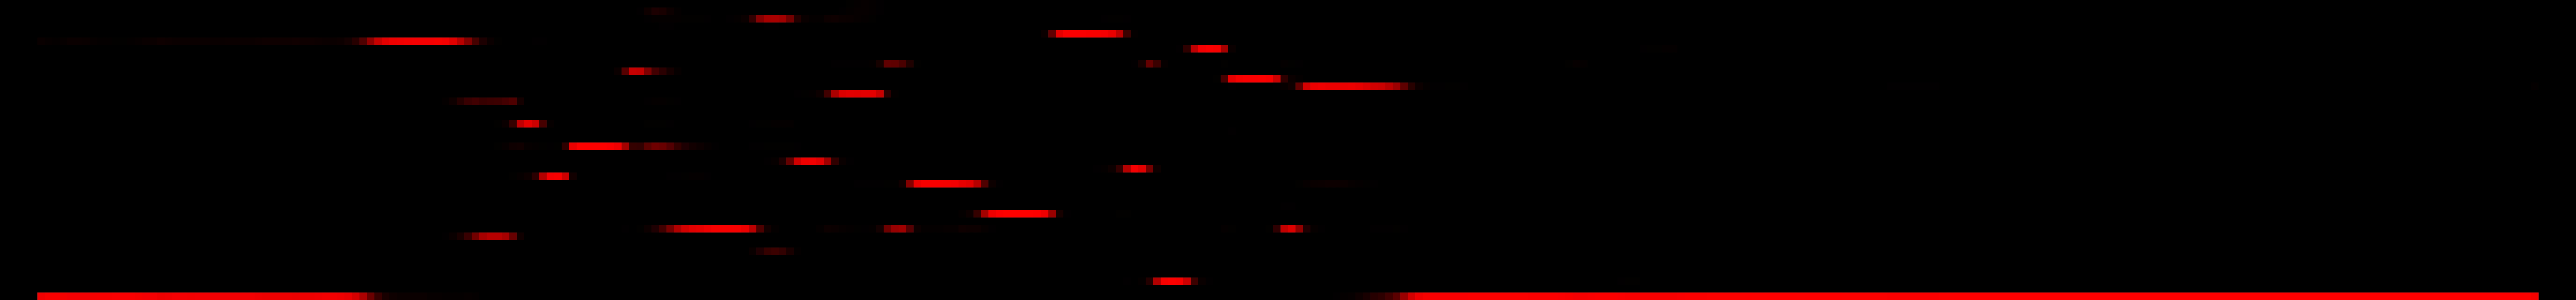

In [96]:
ppg = torch.load(ppg_file)
image_file = audio_file.stem + '.jpg'
ppgs.evaluate.visualize.from_ppg_to_image_file(ppg.T, audio_file, image_file)
IPython.display.Image(image_file)

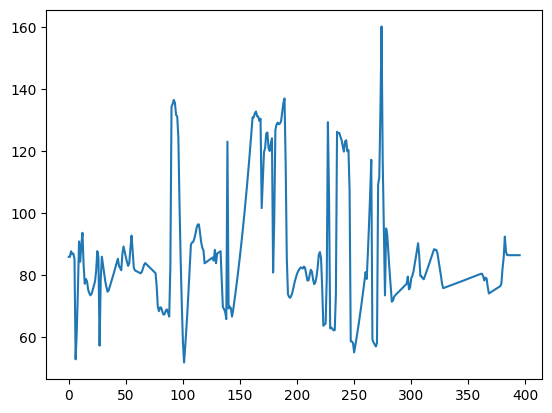

In [40]:
pitch, periodicity, loudness, _ = pysodic.from_audio(
    torchaudio.load(audio_file)[0],
    16000,
    promonet.HOPSIZE / promonet.SAMPLE_RATE,
    promonet.WINDOW_SIZE / promonet.SAMPLE_RATE,
)
plt.plot(pitch.squeeze())